In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import numpy as  np
import pandas as pd
import nltk
import re
from tqdm import tqdm
import tensorflow as tf
from nltk.corpus import stopwords
from prettytable import PrettyTable
import pickle
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
from tensorflow.keras.activations import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
warnings.filterwarnings("ignore")

In [ ]:
with open('../input/itaeng/ita.txt', 'r', encoding="utf8") as file:
    english = []
    italian = []
    for i in file.readlines():
        english.append(i.split("\t")[0])
        italian.append(i.split("\t")[1])
data = pd.DataFrame({'english': english, 'italian': italian})
data.head()

,english,italian
0,Hi.,Ciao!
1,Hi.,Ciao.
2,Run!,Corri!
3,Run!,Corra!
4,Run!,Correte!


In [ ]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    # I have found these characters after observing the data points, feel free to explore more and see if you can do find more
    # you are free to do more proprocessing
    # note that the model will learn better with better preprocessed data 
    
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

,english,italian
0,hi,ciao
1,hi,ciao
2,run,corri
3,run,corra
4,run,correte


In [ ]:
data = data.drop_duplicates(subset=['english','italian'])
data = data.reset_index(drop=True)
data.head()

,english,italian
0,hi,ciao
1,run,corri
2,run,corra
3,run,correte
4,who,chi


In [ ]:
data['italian_len'] = data['italian'].str.split().apply(len)
data = data[data['italian_len'] < 25]

data['english_len'] = data['english'].str.split().apply(len)
data = data[data['english_len'] < 25]

data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'
data['italian'] = '<start> ' + data['italian'].astype(str) + ' <end>'

data = data.drop(['english','italian_len','english_len'], axis=1)
data.head()

,italian,english_inp,english_out
0,<start> ciao <end>,<start> hi,hi <end>
1,<start> corri <end>,<start> run,run <end>
2,<start> corra <end>,<start> run,run <end>
3,<start> correte <end>,<start> run,run <end>
4,<start> chi <end>,<start> who,who <end>


In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2)

In [ ]:
print(train.shape, validation.shape)
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

(280740, 3) (70185, 3)


In [ ]:
train.head()

,italian,english_inp,english_out
239709,<start> non dimentichi di chiudere la porta <end>,<start> do not forget to close the door <end>,do not forget to close the door <end> <end>
47529,<start> io conosco quel suono <end>,<start> i know that sound,i know that sound <end>
332035,<start> non sono il fidanzato di mary sono sol...,<start> i am not mary is boyfriend i am just a...,i am not mary is boyfriend i am just a friend ...
137931,<start> è inutile chiederlo a tom <end>,<start> it is useless to ask tom,it is useless to ask tom <end>
145546,<start> dovreste andare lì adesso <end>,<start> you should go there now,you should go there now <end>


In [ ]:
validation.head()

,italian,english_inp,english_out
202131,<start> per favore scopri dove si trova <end>,<start> please find out where he is,please find out where he is <end>
148016,<start> mi dia una bottiglia di vino <end>,<start> give me a bottle of wine,give me a bottle of wine <end>
336265,<start> io devo fare i miei compiti invece di ...,<start> i have to do my homework instead of go...,i have to do my homework instead of going out ...
118724,<start> ho un po di raffreddore <end>,<start> i have a bit of a cold,i have a bit of a cold <end>
243651,<start> sono convinta che tom non sia colpevol...,<start> i am convinced tom is not guilty,i am convinced tom is not guilty <end>


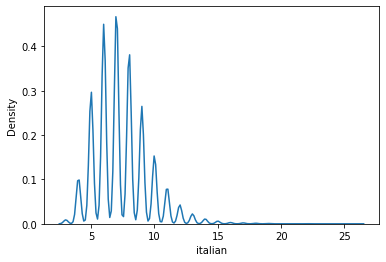

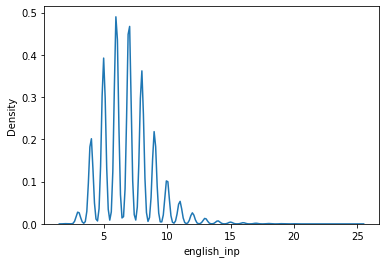

In [ ]:
ita_lengths = train['italian'].str.split().apply(len)
eng_lengths = train['english_inp'].str.split().apply(len)
import seaborn as sns
sns.kdeplot(ita_lengths)
plt.show()
sns.kdeplot(eng_lengths)
plt.show()

In [ ]:
tknizer_ita = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_ita.fit_on_texts(train['italian'].values)
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['english_inp'].values)
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print(vocab_size_ita)

13099
26720


In [ ]:
tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']

(1, 10337)

## <font color='blue'>**Implement custom encoder decoder**</font

<font color='blue'>**Encoder**</font>

In [ ]:
class Encoder(tf.keras.Model):

    def __init__(self, inp_vocab_size, embedding_size, lstm_size, input_length):
        
        super().__init__()
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.input_length = input_length
        self.lstm_size = lstm_size
        self.embed = Embedding(input_dim = self.inp_vocab_size, output_dim = self.embedding_size,
                               input_length = self.input_length, name="Encoder_Embedding")
        self.lstm = LSTM(units = self.lstm_size, return_sequences = True, return_state = True, name="Encoder_LSTM")
        
    def call(self, input_sequence, states = None):
          
        embed_out = self.embed(input_sequence)
        lstm_out, lstm_h, lstm_c = self.lstm(embed_out, states)
        return lstm_out, lstm_h, lstm_c

    def initialize_states(self,batch_size):
        states_h = tf.keras.backend.zeros((batch_size, self.lstm_size))
        state_c = tf.keras.backend.zeros((batch_size, self.lstm_size))
        return states_h, state_c   

      
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.inp_vocab_size = out_vocab_size
        self.embedding_size = embedding_size
        self.input_length = input_length
        self.lstm_size = lstm_size
        self.embed = Embedding(input_dim = self.inp_vocab_size, output_dim = self.embedding_size,
                               input_length = self.input_length, name="Decoder_Embedding")
        self.lstm = LSTM(units = self.lstm_size, return_sequences = True, return_state = True, name="Decoder_LSTM")
  
    def call(self, output_sequence, initial_states):
        embed_out = self.embed(output_sequence)
        lstm_out, lstm_h, lstm_c = self.lstm(embed_out, initial_states)
        return lstm_out, lstm_h, lstm_c  


In [ ]:
def grader_check_encoder():
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units,
        input_length: Length of the input sentence,
        batch_size
    '''
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    #Intialzing encoder 
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    #Intializing encoder initial states
    initial_state=encoder.initialize_states(batch_size)
    
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


In [ ]:
def grader_decoder():
    '''
        out_vocab_size: Unique words of the target language,
        embedding_size: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        input_length: Length of the input sentence,
        batch_size
        
    
    '''
    out_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    states=[state_h,state_c]
    decoder=Decoder(out_vocab_size, embedding_dim, dec_units,input_length )
    output,_,_=decoder(target_sentences, states)
    assert(output.shape==(batch_size,input_length,dec_units))
    return True
print(grader_decoder())

True


In [ ]:
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self, encoder_inputs_length, decoder_inputs_length, output_vocab_size):
        super().__init__()
        self.encoder = Encoder(inp_vocab_size = vocab_size_ita+1, embedding_size = 300, input_length = encoder_inputs_length,
                               lstm_size = 512)
        self.decoder = Decoder(out_vocab_size = vocab_size_eng+1, embedding_size = 300, input_length = decoder_inputs_length,
                               lstm_size = 512)
        self.dense = Dense(output_vocab_size, activation = 'softmax')
    
    def call(self, data):
        inp, targ = data[0], data[1]
        enc_out, state_h, state_c = self.encoder(inp)
        dec_out, _, _ = self.decoder(targ, [state_h, state_c])
        out = self.dense(dec_out)
        return out 

In [ ]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len+1, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len+1, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
batch_size = 1024
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 20)
test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 20)

train_dataloader = Dataloder(train_dataset, batch_size=batch_size)
test_dataloader = Dataloder(test_dataset, batch_size=batch_size)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 20) (1024, 21) (1024, 21)


In [ ]:
## defining callbacks and model and then compiling it
log_dir = "logs/fit/"
earl_stp = tf.keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)

model1 = Encoder_decoder(encoder_inputs_length = 20, decoder_inputs_length = 20, output_vocab_size = vocab_size_eng)          
model1.compile('adam', loss = 'sparse_categorical_crossentropy')

2022-07-12 14:08:41.295168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 14:08:41.411260: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 14:08:41.412078: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 14:08:41.413713: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [ ]:
model1.fit(train_dataloader, validation_data=test_dataloader,
           steps_per_epoch = 150, epochs=10,
           validation_steps = 40, callbacks = [earl_stp])


Epoch 1/10
150/150 [==============================] - 45s 297ms/step - loss: 0.5817 - val_loss: 0.5792
Epoch 2/10
150/150 [==============================] - 44s 295ms/step - loss: 0.5086 - val_loss: 0.5181
Epoch 3/10
150/150 [==============================] - 39s 262ms/step - loss: 0.4411 - val_loss: 0.4587
Epoch 4/10
150/150 [==============================] - 40s 263ms/step - loss: 0.3795 - val_loss: 0.4089
Epoch 5/10
150/150 [==============================] - 40s 264ms/step - loss: 0.3287 - val_loss: 0.3672
Epoch 6/10
150/150 [==============================] - 40s 264ms/step - loss: 0.2854 - val_loss: 0.3346
Epoch 7/10
150/150 [==============================] - 44s 294ms/step - loss: 0.2507 - val_loss: 0.3074
Epoch 8/10
150/150 [==============================] - 40s 263ms/step - loss: 0.2204 - val_loss: 0.2871
Epoch 9/10
150/150 [==============================] - 40s 267ms/step - loss: 0.1949 - val_loss: 0.2699
Epoch 10/10
150/150 [==============================] - 44s 296ms/step - l

In [ ]:
def predict(input_sentence):
    out_text = ''
    seq = tknizer_ita.texts_to_sequences([input_sentence]) 
    pad = pad_sequences(seq, maxlen = 20, dtype='int32', padding='post')
    enc_out, state_h, state_c = model1.encoder(pad)
    intial = np.zeros((1,1), dtype = 'float32')
    intial[0, 0] = tknizer_eng.word_index['<start>']
    states = [state_h, state_c]
    
    for i in range(20):
        predicted_out, state_h, state_c = model1.decoder(intial, initial_states = states)
        out = model1.dense(predicted_out).numpy()
        out = out.reshape(out.shape[-1])
        states = [state_h, state_c] # Update State
        out = np.argmax(out)
        intial = np.zeros((1, 1), dtype = 'float32')
        if tknizer_eng.index_word[out] == '<end>' or i == 20:
            break
        intial[0, 0] = out #Update decoder input
        out_text += tknizer_eng.index_word[out] + ' '
    return out_text

In [ ]:
import nltk.translate.bleu_score as bleu
bleu_score = []
for n in (np.random.randint(0, len(validation), 5)):
    query = validation.italian.values[n]
    pred = predict(query)
    ground = validation.english_inp.values[n]
    ground_ = nltk.tokenize.casual.casual_tokenize(ground)
    pred_ = nltk.tokenize.casual.casual_tokenize(pred)
    bleu_score.append(nltk.translate.bleu_score.sentence_bleu([ground_], pred_)) 
    print("-"*50)
    print("italian Sentence: ", query)
    print("Actual translation: ", ground)
    print("Predicted Translation: ", pred)
print("BLEU score :", np.mean(bleu_score))

--------------------------------------------------
italian Sentence:  <start> parigi è la capitale della francia <end>
Actual translation:  <start> paris is the capital of france
Predicted Translation:  paris is the capital of france 
--------------------------------------------------
italian Sentence:  <start> tom mi assicurò che la pistola non era carica <end>
Actual translation:  <start> tom assured me the gun was not loaded
Predicted Translation:  tom assured me the gun is not a gun 
--------------------------------------------------
italian Sentence:  <start> lui ha risolto il problema da solo <end>
Actual translation:  <start> he solved the problem by himself
Predicted Translation:  he solved the problem by himself 
--------------------------------------------------
italian Sentence:  <start> ho imparato la mia lezione <end>
Actual translation:  <start> i learned my lesson
Predicted Translation:  i have learned my lesson 
--------------------------------------------------
italian

## Task -2: Including Attention mechanisum

1. Use the preprocessed data from Task-1

2. You have to implement an Encoder and Decoder architecture with  
attention as discussed in the reference notebook.

    * Encoder   - with 1 layer LSTM <br>
    * Decoder   - with 1 layer LSTM<br>
    * attention -  (Please refer the <a href= 'https://drive.google.com/file/d/1z_bnc-3aubKawbR6q8wyI6Mh5ho2R1aZ/view?usp=sharing'>**reference notebook**</a> to know more about the attention mechanism.)
3. In Global attention, we have 3 types of scoring functions(as discussed in the reference notebook).
 As a part of this assignment **you need to create 3 models for each scoring function**
<img src='https://i.imgur.com/iD2jZo3.png'>

    * In model 1 you need to implemnt "dot" score function
    * In model 2 you need to implemnt "general" score function
    * In model 3 you need to implemnt "concat" score function.<br>
    
 **Please do add the markdown titles for each model so that we can have a better look at the code and verify.**
4. It is mandatory to train the model with simple model.fit() only, Donot train the model with custom GradientTape()

5. Using attention weights, you can plot the attention plots, 
please plot those for 2-3 examples. You can check about those in <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate">this</a>

6. The attention layer has to be written by yourself only. 
The main objective of this assignment is to read and implement a paper on yourself so please do it yourself.  

7. Please implement the class **onestepdecoder** as mentioned in the assignment instructions.

8. You can use any tf.Keras highlevel API's to build and train the models. 
 Check the reference notebook for better understanding.

9. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

10. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

11. Resources:
    a. Check the reference notebook
    b. <a href="https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/">Resource 1</a>
    c. <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">Resource 2</a>
    d. <a href="https://stackoverflow.com/questions/44238154/what-is-the-difference-between-luong-attention-and-bahdanau-attention#:~:text=Luong%20attention%20used%20top%20hidden,hidden%20state%20at%20time%20t.">Resource 3</a>
    

### <font color='blue'>**Implement custom encoder decoder and attention layers**</font>

<font color='blue'>**Encoder**</font>

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):

        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        super().__init__()
        self.vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.input_length = input_length
        self.lstm_size= lstm_size
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_size, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")
        self.lstm = LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM")

    def call(self,input_sequence,states):
        input_embedd = self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd,initial_state=states)
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c

    
    def initialize_states(self,batch_size):
        initial_state_h=tf.zeros([batch_size,self.lstm_size],dtype=tf.dtypes.float32)
        initial_state_c=tf.zeros([batch_size,self.lstm_size],dtype=tf.dtypes.float32)
        return [initial_state_h , initial_state_c]

<font color='cyan'>**Grader function - 1**</font>

In [ ]:
def grader_check_encoder():
    
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units in encoder,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    initial_state=encoder.initialize_states(batch_size)
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


<font color='blue'>**Attention**</font>

In [ ]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, scoring_function, att_units):
        super().__init__()
        self.scoring_function = scoring_function
        self.att_units = att_units

        if self.scoring_function == 'concat':
            self.W11 = tf.keras.layers.Dense(self.att_units)
            self.W21 = tf.keras.layers.Dense(self.att_units)
            self.v = tf.keras.layers.Dense(1)
            
        elif self.scoring_function == 'general':
            self.W1 = tf.keras.layers.Dense(self.att_units)

  
    def call(self,decoder_hidden_state,encoder_output):
        if self.scoring_function == 'dot':
            decoder_hidden_state = tf.expand_dims(decoder_hidden_state,2)
            similarity = tf.matmul(encoder_output, decoder_hidden_state)

        elif self.scoring_function == 'general':
            decoder_hidden_state = tf.expand_dims(decoder_hidden_state,2)
            weights = self.W1(encoder_output)
            similarity = tf.matmul(weights, decoder_hidden_state)

        elif self.scoring_function == 'concat':
            decoder_hidden_state = tf.expand_dims(decoder_hidden_state,1)
            similarity = self.v(tf.nn.tanh(self.W11(decoder_hidden_state) + self.W21(encoder_output)))
            
        attention_weights = tf.nn.softmax(similarity,axis=1)
        context_vector = attention_weights * encoder_output
        context_vector = tf.reduce_sum(context_vector,axis=1)

        return context_vector,attention_weights

<font color='cyan'>**Grader function - 2**</font>

In [ ]:
def grader_check_attention(scoring_fun):
    
    ''' 
        att_units: Used in matrix multiplications for scoring functions,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    input_length=10
    batch_size=16
    att_units=32
    
    state_h=tf.random.uniform(shape=[batch_size,att_units])
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,att_units])
    attention=Attention(scoring_fun,att_units)
    context_vector,attention_weights=attention(state_h,encoder_output)
    assert(context_vector.shape==(batch_size,att_units) and attention_weights.shape==(batch_size,input_length,1))
    return True
print(grader_check_attention('dot'))
print(grader_check_attention('general'))
print(grader_check_attention('concat'))

True
True
True


In [ ]:
class One_Step_Decoder(tf.keras.Model):
    def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        super().__init__()
        self.vocab_size = tar_vocab_size
        self.embedding_size = embedding_dim
        self.input_length = input_length
        self.lstm_size= dec_units
        self.score_fun = score_fun
        self.att_units = att_units
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_size, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")
        self.lstm = LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM")
        self.dense = Dense(self.vocab_size)
        self.attention=Attention(self.score_fun,self.att_units)

    def call(self,input_to_decoder, encoder_output, state_h,state_c):
        input_embedd = self.embedding(input_to_decoder)
        
        context_vector,attention_weights=self.attention(state_h,encoder_output)
       
        concat_embed = tf.concat([input_embedd,context_vector[:,tf.newaxis,:]],2)
        
        lstm_output, lstm_state_h,lstm_state_c = self.lstm(concat_embed,initial_state=[state_h,state_c])
        decoder_output = self.dense(tf.squeeze(lstm_output,axis=[1]))
        
        return decoder_output,lstm_state_h,lstm_state_c,attention_weights,context_vector

<font color='cyan'>**Grader function - 3**</font>

In [ ]:
def grader_onestepdecoder(score_fun):
    
    '''
        tar_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    tar_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    att_units=16
    batch_size=32
    onestepdecoder=One_Step_Decoder(tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    input_to_decoder=tf.random.uniform(shape=(batch_size,1),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    output,state_h,state_c,attention_weights,context_vector=onestepdecoder(input_to_decoder,encoder_output,state_h,state_c)
    assert(output.shape==(batch_size,tar_vocab_size))
    assert(state_h.shape==(batch_size,dec_units))
    assert(state_c.shape==(batch_size,dec_units))
    assert(attention_weights.shape==(batch_size,input_length,1))
    assert(context_vector.shape==(batch_size,dec_units))
    return True
    
print(grader_onestepdecoder('dot'))
print(grader_onestepdecoder('general'))
print(grader_onestepdecoder('concat'))
    

True
True
True


In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        super().__init__()
        self.vocab_size = out_vocab_size
        self.embedding_dim = embedding_dim
        self.dec_units = dec_units
        self.att_units = att_units
        self.input_length = input_length
        self.score_fun = score_fun
        self.onestepdecoder = One_Step_Decoder(self.vocab_size, self.embedding_dim , self.input_length,
                                               self.dec_units ,self.score_fun ,self.att_units )


    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):
        all_outputs = tf.TensorArray(tf.float32,size=self.input_length,name="output_array")
        for timestep in range(self.input_length):
            output,decoder_hidden_state,decoder_cell_state,attention_weights,context_vector=self.onestepdecoder(input_to_decoder[:,timestep:timestep+1],
                                                                                                           encoder_output,decoder_hidden_state,decoder_cell_state)
            all_outputs = all_outputs.write(timestep,output) 
        all_outputs = tf.transpose(all_outputs.stack(),[1,0,2])
        return all_outputs

<font color='cyan'>**Grader function - 4**</font>

In [ ]:
def grader_decoder(score_fun):
    
    '''
        out_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    out_vocab_size=13 
    embedding_dim=12 
    input_length=11
    dec_units=16 
    att_units=16
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    
    decoder=Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    output=decoder(target_sentences,encoder_output, state_h, state_c)
    assert(output.shape==(batch_size,input_length,out_vocab_size))
    return True
print(grader_decoder('dot'))
print(grader_decoder('general'))
print(grader_decoder('concat'))

True
True
True


In [ ]:
class encoder_decoder(tf.keras.Model):
    def __init__(self,encoder_inputs_length,decoder_inputs_length, output_vocab_size,score_fun,batch_size=128):
        super().__init__()
        self.batch_size=batch_size
        self.encoder = Encoder(inp_vocab_size=vocab_size_ita+1, embedding_size=50, input_length=encoder_inputs_length,
                               lstm_size=256)
        self.decoder = Decoder(out_vocab_size=vocab_size_eng+1, embedding_dim=100, input_length=decoder_inputs_length,
                               dec_units=256 ,score_fun = score_fun ,att_units=256)

    def call(self,data):
        encoder_output,state_h,state_c=self.encoder(data[0],self.encoder.initialize_states(batch_size))
        outputs = self.decoder(data[1],encoder_output,state_h,state_c)
        
        return outputs

In [ ]:
https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    """ Custom loss function that will not consider the loss for padded zeros.
    why are we using this, can't we use simple sparse categorical crossentropy?
    Yes, you can use simple sparse categorical crossentropy as loss like we did in task-1. But in this loss function we are ignoring the loss
    for the padded zeros. i.e when the input is zero then we donot need to worry what the output is. This padded zeros are added from our end
    during preprocessing to make equal length for all the sentences.

    """
    
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len+1, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len+1, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
## splitting data using the above function
batch_size = 128
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 25)
test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 25)

train_dataloader = Dataloder(train_dataset, batch_size=batch_size)
test_dataloader = Dataloder(test_dataset, batch_size=batch_size)


print(train_dataloader[1][0][0].shape, train_dataloader[1][0][1].shape, train_dataloader[1][1].shape)

(128, 25) (128, 26) (128, 26)


In [ ]:
## here we define callbacks and model before compiling it
log_dir = "logs/fit/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
earl_stp = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5,  restore_best_weights=True)
cb = [tensorboard_callback,earl_stp]

model2 = encoder_decoder(25,26,vocab_size_eng,'dot')
optimizer = tf.keras.optimizers.Adam()
model2.compile(optimizer=optimizer,loss=loss_function)

2022-07-12 08:16:35.168346: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-07-12 08:16:35.168400: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-07-12 08:16:35.303689: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-07-12 08:16:35.303860: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [ ]:

train_steps=train.shape[0]//batch_size
valid_steps=validation.shape[0]//batch_size
model2.fit(train_dataloader,
                     steps_per_epoch=train_steps,
                     epochs=10,
                     validation_data=test_dataloader,
                     validation_steps=valid_steps,
                     callbacks=cb,
                     verbose=1)

Epoch 1/10
   1/2193 [..............................] - ETA: 38:59:23 - loss: 2.5122

2022-07-12 08:19:53.384759: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-07-12 08:19:53.384814: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


   2/2193 [..............................] - ETA: 55:21 - loss: 2.4721   

2022-07-12 08:19:54.613925: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-07-12 08:19:54.618931: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-07-12 08:19:54.820913: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 2682 callback api events and 2680 activity events. 
2022-07-12 08:19:54.903747: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-07-12 08:19:54.979518: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fit/train/plugins/profile/2022_07_12_08_19_54

2022-07-12 08:19:55.031348: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/fit/train/plugins/profile/2022_07_12_08_19_54/0512b6484110.trace.json.gz
2022-07-12 08:19:55.118820: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/

2193/2193 [==============================] - 278s 98ms/step - loss: 1.0401 - val_loss: 0.7148
Epoch 2/10
2193/2193 [==============================] - 204s 93ms/step - loss: 0.5751 - val_loss: 0.4690
Epoch 3/10
2193/2193 [==============================] - 203s 93ms/step - loss: 0.3767 - val_loss: 0.3337
Epoch 4/10
2193/2193 [==============================] - 201s 92ms/step - loss: 0.2639 - val_loss: 0.2642
Epoch 5/10
2193/2193 [==============================] - 203s 92ms/step - loss: 0.1994 - val_loss: 0.2286
Epoch 6/10
2193/2193 [==============================] - 202s 92ms/step - loss: 0.1599 - val_loss: 0.2020
Epoch 7/10
2193/2193 [==============================] - 202s 92ms/step - loss: 0.1328 - val_loss: 0.1879
Epoch 8/10
2193/2193 [==============================] - 201s 92ms/step - loss: 0.1139 - val_loss: 0.1790
Epoch 9/10
2193/2193 [==============================] - 201s 92ms/step - loss: 0.0989 - val_loss: 0.1703
Epoch 10/10
2193/2193 [==============================] - 202s 92ms

In [ ]:
def predict(model, input_sentence):
    inputs = input_sentence.split('')
    encoder_seq = tknizer_ita.texts_to_sequences([input_sentence])
    encoder_seq = pad_sequences(encoder_seq, maxlen=25, dtype='int32', padding='post')
    encoder_output,state_h,state_c = model.encoder(encoder_seq,model.encoder.initialize_states(1))
    input_to_decoder = np.array(tknizer_eng.texts_to_sequences(['<start>']))
    outputs = []
    attention_wts = []
    count = 0,
    while True:
        output,state_h,state_c,attention_weights,context_vector=model.decoder.onestepdecoder(input_to_decoder,
                                                                                    encoder_output,state_h,state_c)
        eng_id = tf.math.argmax(output[0]).numpy()
        eng_word = tknizer_eng.sequences_to_texts([[eng_id]])
        input_to_decoder = np.array(tknizer_eng.texts_to_sequences(eng_word))
        count += 1
        if count == 26 or eng_word[0] == '<end>':
            break
        outputs.append(eng_word[0])
        attention_wts.append(tf.squeeze(attention_weights).numpy()[:len(inputs)])
    attention_wts = np.array(attention_wts)
    return(outputs,np.array(attention_wts))

In [ ]:
## predictions on model 2
for i,row in train.sample(4).iterrows():
    print('='*80)
    print("Italian Sentence: " ,row['italian'].replace('<start> ','').replace(' <end>',''))
    print("Acutual Translation: " ,row['english_inp'].replace('<start> ',''))
    print("Attention Weights: ")
    outputs,attention_wts = predict(model2,row['italian'])
    print("Predicted Translation: "," ".join(outputs))

Italian Sentence:  odio i suoi genitori
Acutual Translation:  i hate her parents
Attention Weights: 
Predicted Translation:  i hate your parents
Italian Sentence:  sembra che lei sappia molto
Acutual Translation:  you seem to know a lot
Attention Weights: 
Predicted Translation:  it sounds like you know a lot
Italian Sentence:  sei patetico
Acutual Translation:  you are pathetic
Attention Weights: 
Predicted Translation:  you are pathetic
Italian Sentence:  dovresti saperlo
Acutual Translation:  you should know that
Attention Weights: 
Predicted Translation:  you should know that


In [ ]:
## bleu score on model 2
bleu_scores0 = []
for index, row in validation.sample(1000).iterrows():
    translation,at_wts = predict(model2,row['italian'])
    ref = [row['english_inp'].replace('<start> ','').split()]
    bleu_scores0.append(bleu.sentence_bleu(ref, translation))
blscr = np.mean(bleu_scores)
print("BLEU score:", blscr)

BLEU score: 0.7932563189341217


In [ ]:
## defining callbacks and defining model 3 before compiling the model
log_dir = "logs3/fit/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
earl_stp = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3,  restore_best_weights=True)
cb = [tensorboard_callback,earl_stp]

model3 = encoder_decoder(25,26,vocab_size_eng,'general')
optimizer = tf.keras.optimizers.Adam()
model3.compile(optimizer=optimizer,loss=loss_function)

In [ ]:
## fitting model 3
model3.fit(train_dataloader, steps_per_epoch=train.shape[0]//batch_size,
                     epochs=5,validation_data=test_dataloader,
                     validation_steps=validation.shape[0]//batch_size,
                     callbacks=cb,verbose=1)

2022-07-12 10:17:48.892648: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-07-12 10:17:48.892699: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-07-12 10:17:49.069703: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-07-12 10:17:49.069894: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Epoch 1/5
   1/2193 [..............................] - ETA: 19:21:39 - loss: 2.5720

2022-07-12 10:18:22.441806: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-07-12 10:18:22.441866: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


   2/2193 [..............................] - ETA: 56:07 - loss: 2.5091   

2022-07-12 10:18:23.966730: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-07-12 10:18:23.972713: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-07-12 10:18:24.128876: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 2856 callback api events and 2854 activity events. 
2022-07-12 10:18:24.199680: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-07-12 10:18:24.277743: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fit/train/plugins/profile/2022_07_12_10_18_24

2022-07-12 10:18:24.327145: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/fit/train/plugins/profile/2022_07_12_10_18_24/0512b6484110.trace.json.gz


   3/2193 [..............................] - ETA: 59:31 - loss: 2.5287

2022-07-12 10:18:24.417073: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fit/train/plugins/profile/2022_07_12_10_18_24

2022-07-12 10:18:24.425992: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/fit/train/plugins/profile/2022_07_12_10_18_24/0512b6484110.memory_profile.json.gz
2022-07-12 10:18:24.429321: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/fit/train/plugins/profile/2022_07_12_10_18_24
Dumped tool data for xplane.pb to logs/fit/train/plugins/profile/2022_07_12_10_18_24/0512b6484110.xplane.pb
Dumped tool data for overview_page.pb to logs/fit/train/plugins/profile/2022_07_12_10_18_24/0512b6484110.overview_page.pb
Dumped tool data for input_pipeline.pb to logs/fit/train/plugins/profile/2022_07_12_10_18_24/0512b6484110.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to logs/fit/train/plugins/profile/2022_07_12_10_18_24/05

2193/2193 [==============================] - 260s 104ms/step - loss: 1.0214 - val_loss: 0.7024
Epoch 2/5
2193/2193 [==============================] - 216s 99ms/step - loss: 0.5664 - val_loss: 0.4671
Epoch 3/5
2193/2193 [==============================] - 215s 98ms/step - loss: 0.3793 - val_loss: 0.3451
Epoch 4/5
2193/2193 [==============================] - 217s 99ms/step - loss: 0.2711 - val_loss: 0.2713
Epoch 5/5
2193/2193 [==============================] - 217s 99ms/step - loss: 0.2065 - val_loss: 0.2313


In [ ]:
## sampled predictions for model 3
for i,row in train.sample(4).iterrows():
    print('-'*50)
    print("Italian Sentence: " ,row['italian'].replace('<start> ','').replace(' <end>',''))
    print("Acutual Translation: " ,row['english_inp'].replace('<start> ',''))
    print("Attention Weights: ")
    outputs,attention_wts = predict(model3,row['italian'])
    print("Predicted Translation: "," ".join(outputs))

--------------------------------------------------
Italian Sentence:  avresti dovuto seguire gli ordini di tom
Acutual Translation:  you should have followed tom is orders
Attention Weights: 
Predicted Translation:  you should have followed tom is orders
--------------------------------------------------
Italian Sentence:  tom dove lha sentito
Acutual Translation:  where did tom hear that
Attention Weights: 
Predicted Translation:  where did tom hear it
--------------------------------------------------
Italian Sentence:  ho appena dato a tom trenta dollari
Acutual Translation:  i just gave tom thirty dollars
Attention Weights: 
Predicted Translation:  i just gave tom thirty dollars
--------------------------------------------------
Italian Sentence:  suonerò una sonata per lei
Acutual Translation:  i will play a sonata for you
Attention Weights: 
Predicted Translation:  i will play a sonata for you


In [ ]:
## BLEU score on pred data
bleu_scores0 = []
for index, row in validation.sample(1000).iterrows():
    translation,at_wts = predict(model3,row['italian'])
    ref = [row['english_inp'].replace('<start> ','').split()]
    bleu_scores0.append(bleu.sentence_bleu(ref, translation))
blscr = np.mean(bleu_scores    
print("BLEU score:", blscr))

BELU score: 0.7367810563104376


In [ ]:
## defining callbacks and the model before compiling the model
log_dir = "logs4/fit/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
earl_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3,  restore_best_weights=True)
cb = [tensorboard_callback,earl_stop]

model4 = encoder_decoder(25,26,vocab_size_eng,'concat')
optimizer = tf.keras.optimizers.Adam()
model4.compile(optimizer=optimizer,loss=loss_function)

In [ ]:
## fitting the model
model4.fit(train_dataloader, steps_per_epoch=train.shape[0]//batch_size,
                     epochs=5, validation_data=test_dataloader,
                     validation_steps=validation.shape[0]//batch_size,
                     callbacks=cb, verbose=1)

Epoch 1/5
   1/2193 [..............................] - ETA: 4:47 - loss: 1.1008

2022-07-12 10:40:36.542364: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-07-12 10:40:36.542428: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


   2/2193 [..............................] - ETA: 1:03:39 - loss: 1.0797

2022-07-12 10:40:36.922952: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-07-12 10:40:36.927629: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-07-12 10:40:37.102906: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 3395 callback api events and 3393 activity events. 
2022-07-12 10:40:37.184686: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-07-12 10:40:37.279958: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs4/fit/train/plugins/profile/2022_07_12_10_40_37

2022-07-12 10:40:37.343456: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs4/fit/train/plugins/profile/2022_07_12_10_40_37/0512b6484110.trace.json.gz


   3/2193 [..............................] - ETA: 44:27 - loss: 1.0777  

2022-07-12 10:40:37.462390: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs4/fit/train/plugins/profile/2022_07_12_10_40_37

2022-07-12 10:40:37.473437: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs4/fit/train/plugins/profile/2022_07_12_10_40_37/0512b6484110.memory_profile.json.gz
2022-07-12 10:40:37.478425: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs4/fit/train/plugins/profile/2022_07_12_10_40_37
Dumped tool data for xplane.pb to logs4/fit/train/plugins/profile/2022_07_12_10_40_37/0512b6484110.xplane.pb
Dumped tool data for overview_page.pb to logs4/fit/train/plugins/profile/2022_07_12_10_40_37/0512b6484110.overview_page.pb
Dumped tool data for input_pipeline.pb to logs4/fit/train/plugins/profile/2022_07_12_10_40_37/0512b6484110.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to logs4/fit/train/plugins/profile/2022_07_12_10_4

2193/2193 [==============================] - 269s 123ms/step - loss: 0.7719 - val_loss: 0.5639
Epoch 2/5
2193/2193 [==============================] - 257s 117ms/step - loss: 0.4445 - val_loss: 0.3691
Epoch 3/5
2193/2193 [==============================] - 257s 117ms/step - loss: 0.2923 - val_loss: 0.2767
Epoch 4/5
2193/2193 [==============================] - 257s 117ms/step - loss: 0.2119 - val_loss: 0.2282
Epoch 5/5
2193/2193 [==============================] - 257s 117ms/step - loss: 0.1657 - val_loss: 0.2042


In [ ]:
## sampled predictions for model 4
for i,row in train.sample(4).iterrows():
    print('-'*50)
    print("Italian Sentence: " ,row['italian'].replace('<start> ','').replace(' <end>',''))
    print("Acutual Translation: " ,row['english_inp'].replace('<start> ',''))
    print("Attention Weights: ")
    outputs,attention_wts = predict(model4,row['italian'])
    print("Predicted Translation: "," ".join(outputs))

--------------------------------------------------
Italian Sentence:  io non ho finito
Acutual Translation:  i am not done
Attention Weights: 
Predicted Translation:  i am not done
--------------------------------------------------
Italian Sentence:  tom chiese a mary di dargli un po di denaro
Acutual Translation:  tom asked mary to give him some money
Attention Weights: 
Predicted Translation:  tom asked mary to give me some money
--------------------------------------------------
Italian Sentence:  mio nonno sarebbe spesso a leggere e studiare su questa scrivania
Acutual Translation:  my grandfather would often read and study at this desk
Attention Weights: 
Predicted Translation:  my grandfather would often eat reading that morning on the desk
--------------------------------------------------
Italian Sentence:  non sei stupido
Acutual Translation:  you are not stupid
Attention Weights: 
Predicted Translation:  you are not stupid


In [ ]:
## bleu score for model 4
bleu_scores = []
for index, row in validation.sample(1000).iterrows():
    translation,at_wts = predict(model4,row['italian'])
    reference = [row['english_inp'].replace('<start> ','').split()]
    bleu_scores.append(bleu.sentence_bleu(reference, translation))
    
print("BLEU score:", np.mean(bleu_scores))

BLEU score: 0.7573654946372658


## ***Observations***

*out of concat, general and dot, dot gives the best BLEU score of arounf 0,8*

*all three have more or less similar BLEU score, with DOT taking the mantle*